In [2]:
%matplotlib inline
# from ExKMC.Tree import Tree # import from cloned local library followed by installing manually
import sys
sys.path.append('../')
from ExKMC_M.ExKMC.Tree import Tree

import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, normalize
from utils import plot_confusion_matrix,silhouette_score,f_a_score,to_csv,get_distance,fs_FRUFS,getMojofm,get_similarity,plot_count,getFeatureMatch
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from IPython.display import Image



from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN
from collections import Counter

import seaborn as sns

from multi_imbalance.resampling.soup import SOUP
from multi_imbalance.resampling.global_cs import GlobalCS
from multi_imbalance.resampling.mdo import MDO

## Data preprocessing

In [117]:
# input data
DF = pd.read_csv('/home/sfy/Documents/VScodeProject/Thesis/data/family.csv',index_col=False)
print(f'Data shape is {DF.shape}')

grouped = DF.groupby(['family'])
# get numbers of each group 
groupCount = grouped['family'].count().sort_values(ascending=False)

table_count = groupCount.sort_values(ascending=False)[:20]
print(table_count)
# select by numbers of the top 
# TOP = 11
TOP = 10

selected = groupCount.sort_values(ascending=False)[:TOP]
# plot_count(selected)

# get names
selectedNames = list(selected.index)
print(f"selected family are {selectedNames}")

# select trained
train = DF.loc[DF["family"].isin(selectedNames)]
train.reset_index(inplace=True, drop=True)
print(f"train dataset shape {train.shape}")


# encode into encoder
le = LabelEncoder()
label = le.fit_transform(train["family"])
# print(train.head(5))

# exclue name -> X_
train = train.loc[:, train.columns != "name"]
train = train.loc[:, train.columns != "family"]

# remove duplicates -> X
# parameter with first and last ? !!!! can be discussed
# X = train.drop_duplicates(keep='last')
X = train

# with X.index canbe reserved to original labels
Y = np.take(label, X.index)

print(f"Without duplications wi shape {X.shape}")
print(f"With duplications wi shape {train.shape}")

X.reset_index(inplace=True, drop=True)

# X.head(5)
# X.to_csv('testDup.csv',index=False)

Data shape is (20760, 698)
family
Airpush         6652
FakeInst        2168
Mecor           1820
Youmi           1300
Fusob           1262
Kuguo           1197
Dowgin           862
BankBot          647
Jisut            558
DroidKungFu      546
RuMMS            402
Lotoor           329
Mseg             235
Boqx             215
Minimob          203
Triada           197
Kyview           175
SlemBunk         174
SimpleLocker     172
SmsKey           165
Name: family, dtype: int64
selected family are ['Airpush', 'FakeInst', 'Mecor', 'Youmi', 'Fusob', 'Kuguo', 'Dowgin', 'BankBot', 'Jisut', 'DroidKungFu']
train dataset shape (17012, 698)
Without duplications wi shape (17012, 696)
With duplications wi shape (17012, 696)


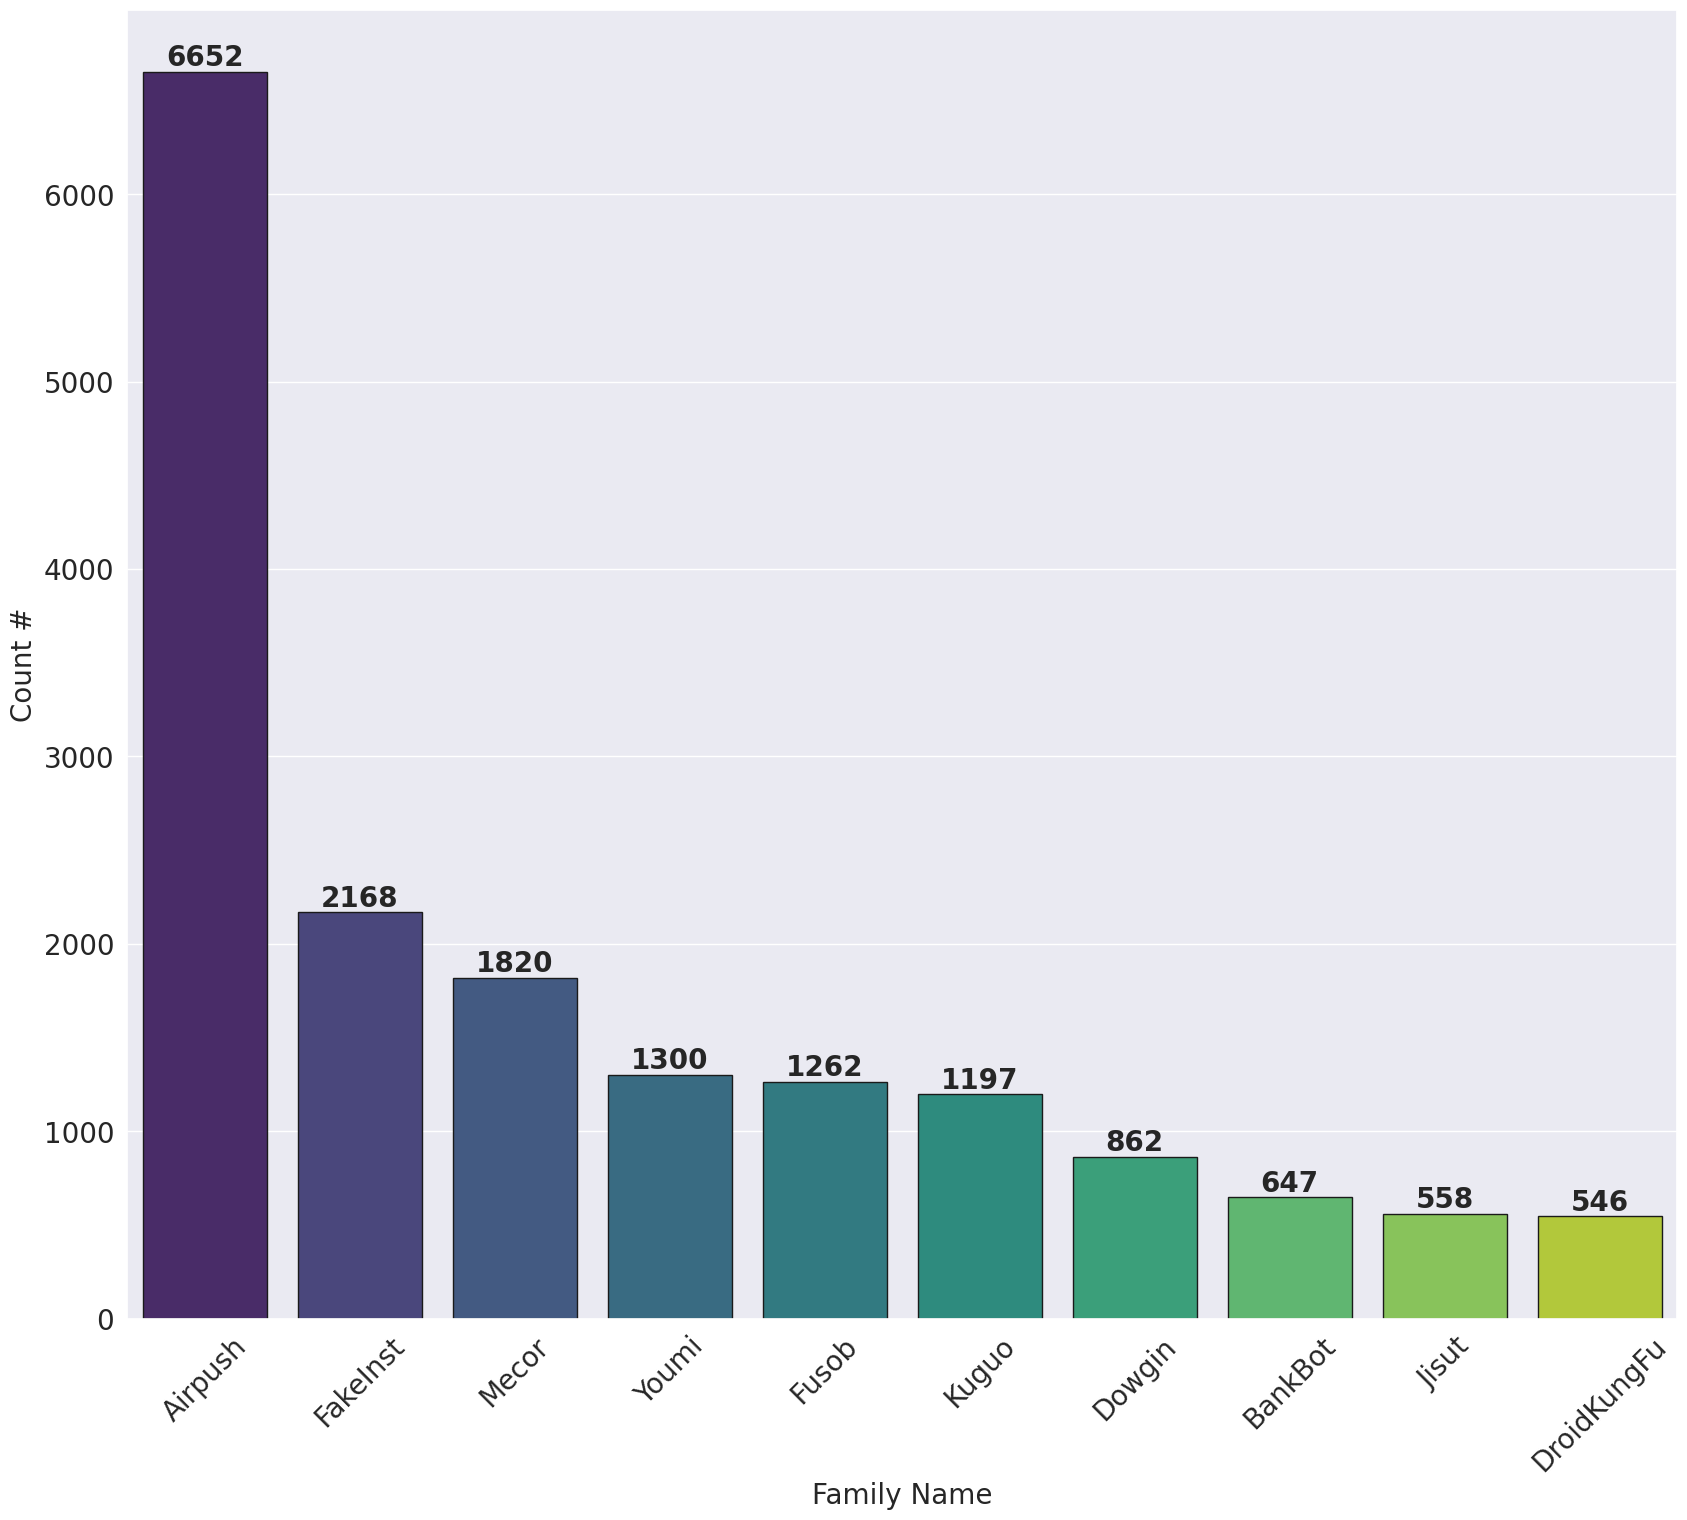

In [119]:
# Plot the distribution graph with Seaborn
# sns.histplot(count, kde=True, color='purple')

# for top 10 
data = selected
font_size = 20

# top 20 
# data = table_count

sns.set(rc={'figure.figsize': (20, 17)})

sns.barplot(x=data.index, y=data.values,palette='viridis')

for container in plt.gca().containers:
    plt.setp(container, edgecolor='k')

for i, v in enumerate(data.values):
    plt.text(i, v, str(v), ha='center', va='bottom',fontweight='bold', fontsize=font_size)


# Set labels and title
plt.xlabel('Family Name',fontsize = font_size)
plt.ylabel('Count #',fontsize = font_size)
# plt.title('Distribution Graph of Top 20 Families')

plt.xticks(rotation=45,fontsize = font_size)
plt.yticks(fontsize = font_size)

# Display the graph
plt.savefig('distribution_top_10')
plt.show()


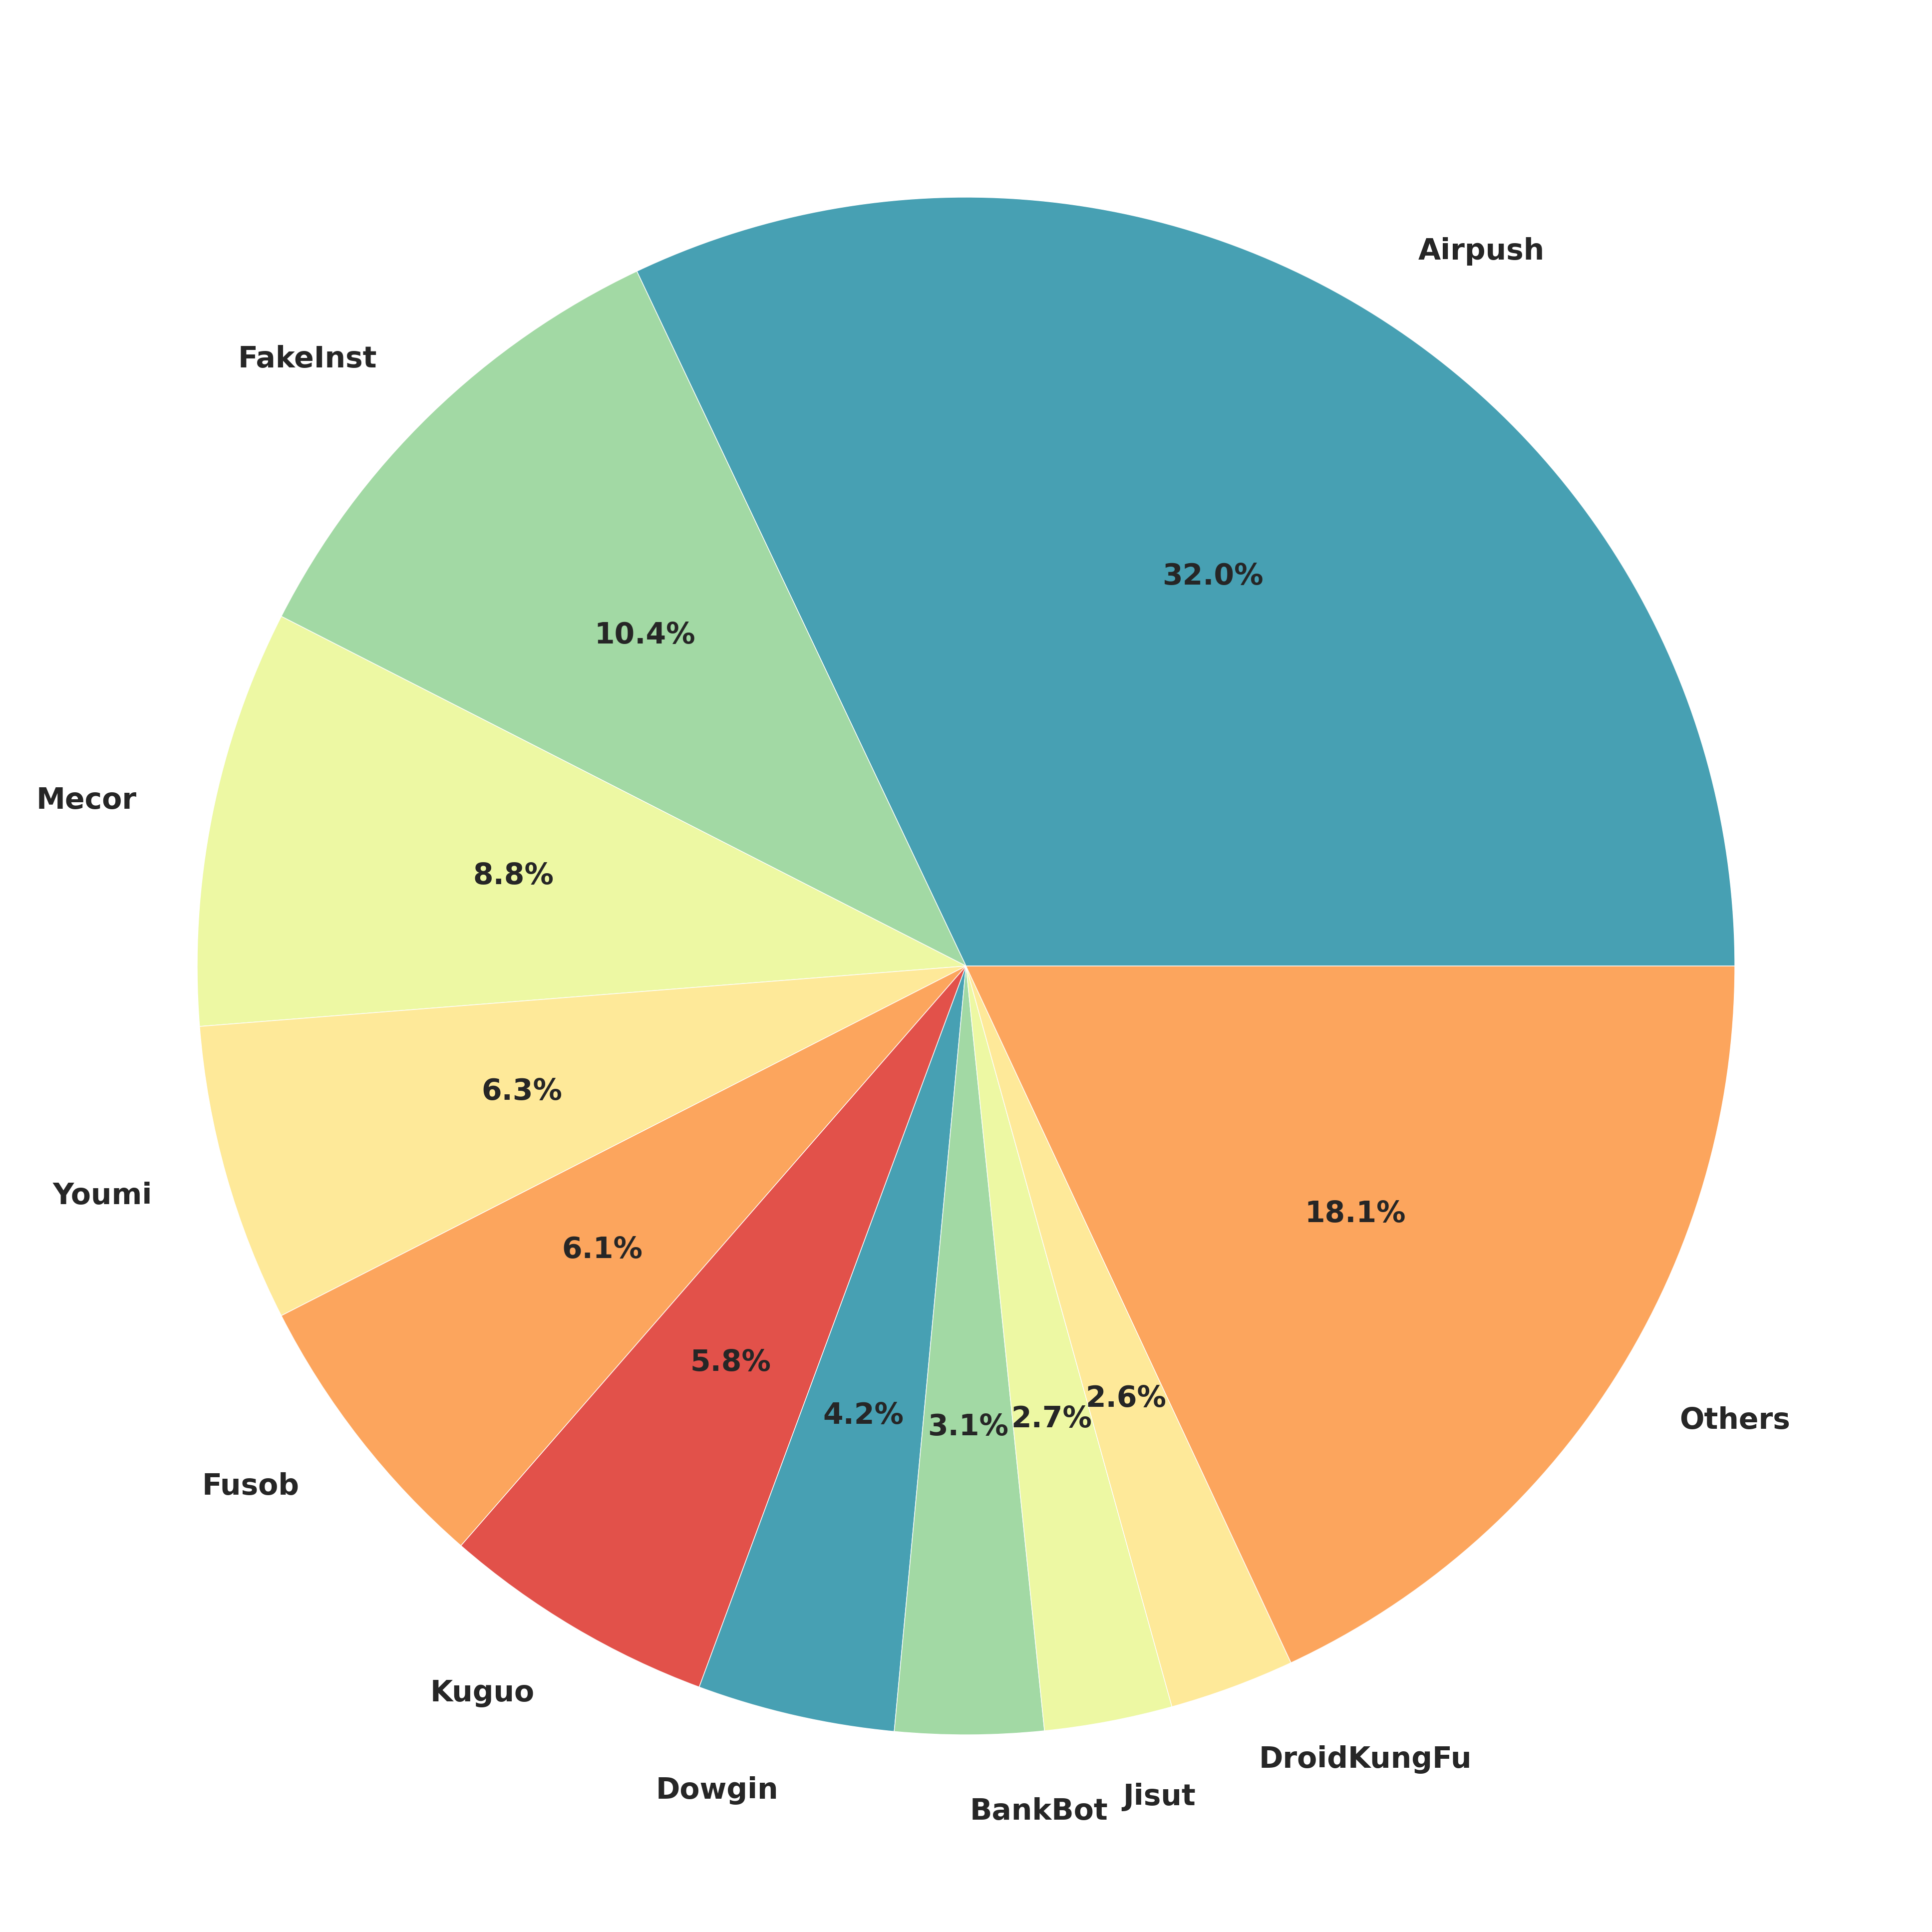

In [113]:
# plot the pie chart in seaborn

data_pie = selected
# plot pie data : exclude the others 
others = DF.shape[0] - selected.sum()
#concat others and top 10 
data_pie['Others'] = others

# Define custom colors using Seaborn's color palette
colors = sns.color_palette('Spectral')
colors.reverse()
# colors = sns.color_palette('ch:start=2, rot=0, dark=0, light=.95')


sns.set(rc={'figure.figsize': (50, 50)})
# Filter the data and labels based on the condition
# labels = data_pie.index
# total = data_pie.sum()

# filtered_data = data_pie[data_pie / total >= 0.02]
# filtered_labels_noLabel = ['' if value / total < 0.02 else label for label, value in zip(labels, data_pie)]
# filtered_labels = [label for label, value in zip(labels, data_pie) if value / total >= 0.02]

font = {
        'weight': 'bold',
        'size': 42}

# Create a pie chart
plt.pie(data_pie.values, labels=data_pie.index, colors=colors,autopct='%1.1f%%', textprops=font)

# Create a pie chart using matplotlib with custom colors
# plt.pie(x = data_pie.values, labels=data_pie.index, colors=colors, autopct='%1.1f%%')

# Display the chart
plt.savefig('pie_top_10')
plt.show()

In [114]:
others

3748

before sampling
[(0, 6652), (1, 647), (2, 862), (3, 546), (4, 2168), (5, 1262), (6, 558), (7, 1197), (8, 1820), (9, 1300)]
after sampling
[(0, 546), (1, 546), (2, 546), (3, 546), (4, 546), (5, 546), (6, 546), (7, 546), (8, 546), (9, 546)]


Progress bar: 100%|██████████| 696/696 [00:18<00:00, 38.01it/s] 


--Result of cluster 0 the largest is Jisut with 0.9479166666666666
--Result of cluster 1 the largest is Fusob with 1.0
--Result of cluster 2 the largest is Airpush with 0.5082765335929893
--Result of cluster 3 the largest is BankBot with 0.4267399267399267
--Result of cluster 4 the largest is DroidKungFu with 0.4426807760141093
--Result of cluster 5 the largest is FakeInst with 0.6275862068965518
--Result of cluster 6 the largest is DroidKungFu with 0.014571948998178506
--Result of cluster 7 the largest is Youmi with 0.3514644351464435
--Result of cluster 8 the largest is Mecor with 1.0
--Result of cluster 9 the largest is DroidKungFu with 0.020146520146520148
{'Dowgin', 'Kuguo'}
85.39


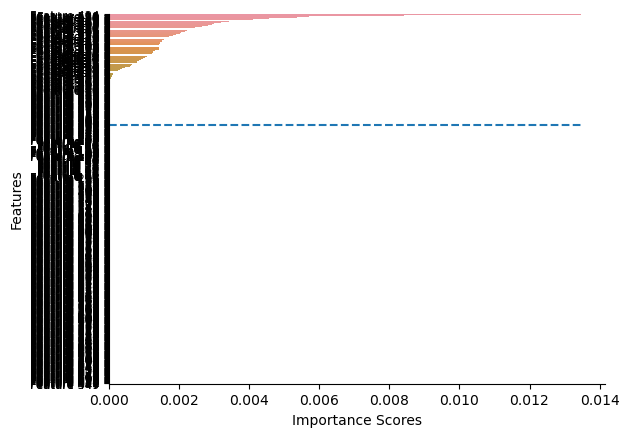

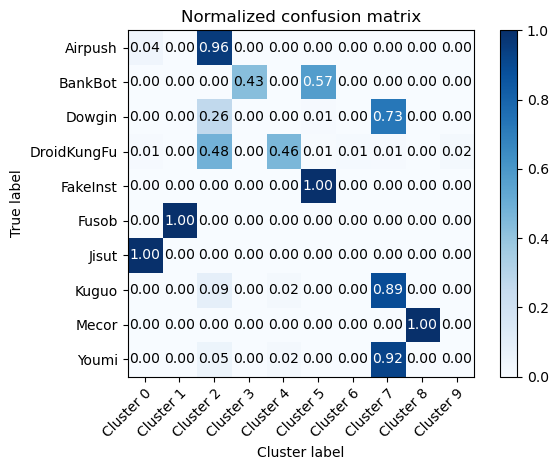

In [3]:
# from sklearn.feature_selection import VarianceThreshold,GenericUnivariateSelect,chi2
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=0)

K = len(selectedNames)
X_train = X
X_train.shape

# success with variance
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X_train)

# imbalanced data

# smote_enn = SMOTEENN(random_state=0)

# X_resampled, y_resampled = smote_enn.fit_resample(X, Y)
# print(sorted(Counter(y_resampled).items()))
############
clf = NearMiss(version=1)
# clf = SMOTEENN(random_state=42)

# clf = GlobalCS()
print('before sampling')
print(sorted(Counter(Y).items()))

resampled_X, resampled_y = clf.fit_resample(scaled_df, Y)
# resampled_X, resampled_y = nm1.fit_resample(X, Y)

print('after sampling')
print(sorted(Counter(resampled_y).items()))
# checek resampeld data count


# Converting the numpy array into a pandas DataFrame
X_train_ = pd.DataFrame(resampled_X)

# values = np.arange(0.10,0.13,0.005)
# for i in values:
#     print(f'starting {i} ')


# feature selection
# k = float(0.1155555555555555555555)
# 0.035-67.83  0.08- 67.43 
X_train_prued = fs_FRUFS(X_train_,k=0.3,display=True,iter=0)
# X_train_prued = fs_FRUFS(X_train_,k=0.12,display=False)


###---------------------training --------------------------------------
#models
kmeans = KMeans(K,random_state=0)
kmeans.fit(X_train_prued)


# f_a_score(Y, kmeans_labels, tree_labels=tree_labels)
kmeans.inertia_
get_similarity(y_true = resampled_y,y_predict = kmeans.labels_,le = le,wholeList= selectedNames,display=True)



# class_names = np.array(list(le.inverse_transform([_ for _ in range(TOP)])))
class_names = np.array(list(le.inverse_transform([_ for _ in range(TOP)])))
plot_confusion_matrix(resampled_y,kmeans.labels_,class_names,normalize=True)
# plt.savefig(f"confusion_mat_fs{k}.png")
# plt.show()

### MoJofm for result

getMojofm(index_X=X_train_prued.index,predict=kmeans.labels_,y_true=resampled_y)


# output dataset to table
# to_csv(X_train_prued, resampled_y, train)
X_train_prued.shape

# X_train_prued_round = X_train_prued.round(4)
# to_csv(X_train_prued_round, resampled_y)

# feature names
features = getFeatureMatch(X_train, X_train_prued)
features

## Visualize for sampling

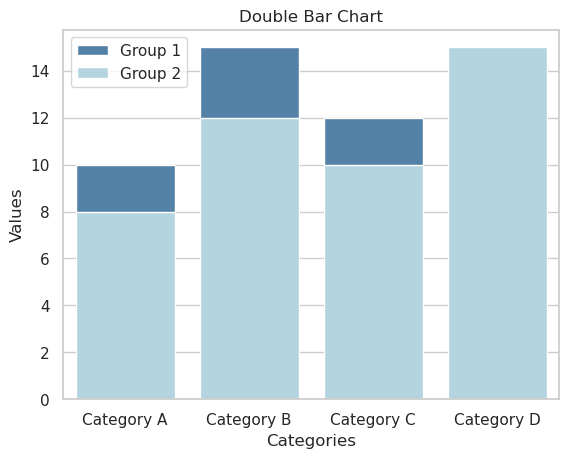

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample data
categories = ['Category A', 'Category B', 'Category C', 'Category D']
group1 = [10, 15, 12, 8]  # Values for the first group
group2 = [8, 12, 10, 15]  # Values for the second group

# Combine the data into a DataFrame
data = pd.DataFrame({'Category': categories, 'Group 1': group1, 'Group 2': group2})

# Plotting the double bar chart
sns.set(style="whitegrid")  # Set the style of the chart
sns.barplot(x='Category', y='Group 1', data=data, color='steelblue', label='Group 1')
sns.barplot(x='Category', y='Group 2', data=data, color='lightblue', label='Group 2')

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Double Bar Chart')

# Display the legend
plt.legend()

# Show the plot
plt.show()


In [5]:
# list(le.inverse_transform([0,3,4,7,9]))

list(le.inverse_transform([_ for _ in range(10)]))
# get_distance(kmeans, tree,X_train_,Y)


['Airpush',
 'BankBot',
 'Dowgin',
 'DroidKungFu',
 'FakeInst',
 'Fusob',
 'Jisut',
 'Kuguo',
 'Mecor',
 'Youmi']